In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

RANDOM_SEED = 42

In [2]:
# Para la compatibilidad de GPU y tensorflow uso
# tensorflow==2.10.1
# cuda = 11.2
# cudnn = 8.1.1
# python = 3.10.9
# https://www.tensorflow.org/install/source_windows?#gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("GPUs Available: ", gpus)
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
      print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Especificación de cada ruta

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
labels = 'model/keypoint_classifier/keypoint_classifier_label.csv'

# Configuración del número de clasificaciones

In [4]:
# Leer el contenido del archivo, eliminando el BOM si está presente
with open(labels, 'r', encoding='utf-8-sig') as f:
    content = f.read().splitlines()

# Convertir el contenido a un array de NumPy
labels_name = np.array(content, dtype=str)

print(labels_name)
NUM_CLASSES = len(labels_name)

['Open' 'Close' 'Pointer' 'mouse_up' 'mouse_down' 'mouse_right'
 'mouse_left' 'Ok' 'palma']


# Carga de datos de entrenamiento

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.60, random_state=RANDOM_SEED)

In [8]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=RANDOM_SEED)

# Construcción del modelo

In [9]:
from keras.regularizers import l2
model = keras.models.Sequential([
    keras.layers.Input((21 * 2, )),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 64)                2752      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 9)                 1

In [11]:
# Callback de punto de control del modelo
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para detención temprana
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [12]:
# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo

In [13]:
# Entrenar el modelo y guardar la historia
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/50
405/416 [============================>.] - ETA: 0s - loss: 1.6565 - accuracy: 0.4678
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
416/416 [==============================] - 5s 5ms/step - loss: 1.6456 - accuracy: 0.4715 - val_loss: 0.9857 - val_accuracy: 0.7235
Epoch 2/50
410/416 [============================>.] - ETA: 0s - loss: 1.1821 - accuracy: 0.6457
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
416/416 [==============================] - 2s 5ms/step - loss: 1.1801 - accuracy: 0.6459 - val_loss: 0.7846 - val_accuracy: 0.7803
Epoch 3/50
409/416 [============================>.] - ETA: 0s - loss: 1.0502 - accuracy: 0.6834
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
416/416 [==============================] - 2s 5ms/step - loss: 1.0488 - accuracy: 0.6844 - val_loss: 0.7058 - val_accuracy: 0.7951
Epoch 4/50
407/416 [============================>.] - ETA: 0s - loss: 0.9744 - accuracy:

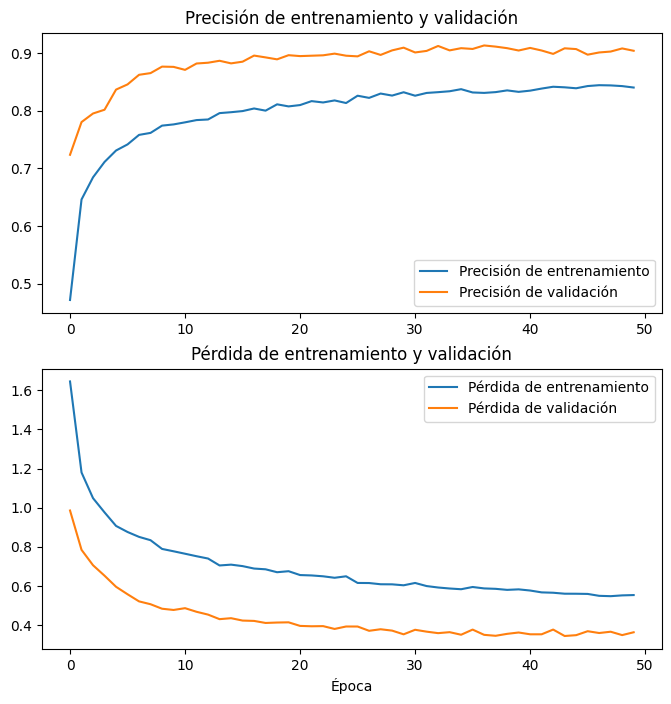

In [14]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

# Graficar la pérdida
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.show()

In [15]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_val, y_val, batch_size=128)

35/35 [==============================] - 0s 7ms/step - loss: 0.3753 - accuracy: 0.9008


In [16]:
# Carga del modelo guardado
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Prueba de inferencia
predict_result = model.predict(np.array([X_val[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 81ms/step
[4.5628999e-03 2.9932818e-04 1.4964362e-04 9.5404475e-06 1.2507920e-05
 9.9142319e-01 4.2856012e-08 3.5409092e-03 1.9207764e-06]
5


# Matriz de confusión

139/139 [==============================] - 0s 2ms/step


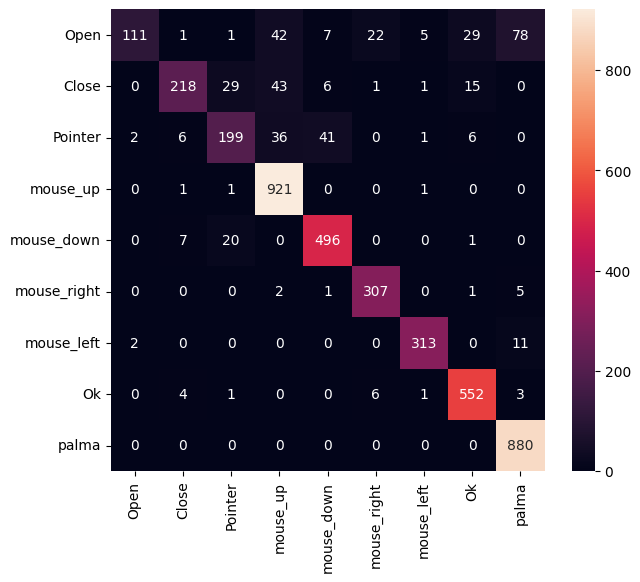

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.38      0.54       296
           1       0.92      0.70      0.79       313
           2       0.79      0.68      0.73       291
           3       0.88      1.00      0.94       924
           4       0.90      0.95      0.92       524
           5       0.91      0.97      0.94       316
           6       0.97      0.96      0.97       326
           7       0.91      0.97      0.94       567
           8       0.90      1.00      0.95       880

    accuracy                           0.90      4437
   macro avg       0.91      0.84      0.86      4437
weighted avg       0.90      0.90      0.89      4437



In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, labels_name, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=range(len(labels_name)))
    
    df_cmx = pd.DataFrame(cmx_data, index=labels_name, columns=labels_name)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_val, y_pred))

Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_val, y_pred, labels_name)

# Conversión a modelo para Tensorflow-Lite

In [19]:
# Guardar como modelo exclusivamente para inferencia
model.save(model_save_path, include_optimizer=False)

In [20]:
# Modelo de conversión (cuantificación)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmp_j3r2do8\assets


10472

# Prueba de inferencia

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [22]:
# Obtener tensores de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_val[0]]))

In [24]:
%%time
# Realizar inferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4 ms


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.5554484e-03 2.9651108e-04 1.4843598e-04 9.6930435e-06 1.2019251e-05
 9.9146551e-01 4.0621281e-08 3.5104821e-03 1.7714622e-06]
5
